<div>
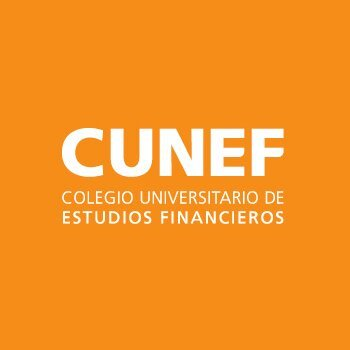
</div>

# **Número de turistas en España**

## *Librerías*

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from sktime.forecasting.arima import AutoARIMA
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

## *Lectura del csv y preparación de los datos*

Se procede a la lectura del CSV del tráfico de turistas en España.
- Fuente: https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736176996&menu=ultiDatos&idp=1254735576863

In [12]:
df_turismo = pd.read_csv("turismo.csv", delimiter=";")
df_turismo

,Comunidades autónomas,Tipo de dato,Periodo,Total
0,Total,Dato base,2022M02,3.156.809
1,Total,Dato base,2022M01,2.486.486
2,Total,Dato base,2021M12,2.947.525
3,Total,Dato base,2021M11,3.361.913
4,Total,Dato base,2021M10,5.148.820
...,...,...,...,...
2459,Otras Comunidades Autónomas,Tasa de variación acumulada,2016M02,"-3,51"
2460,Otras Comunidades Autónomas,Tasa de variación acumulada,2016M01,"-8,65"
2461,Otras Comunidades Autónomas,Tasa de variación acumulada,2015M12,NaN
2462,Otras Comunidades Autónomas,Tasa de variación acumulada,2015M11,NaN


En el dataframe se puede apreciar que hay valores en las filas. Se procede a ver los valores únicos para escoger los datos con lo que se va a trabajar para la tesis.

In [13]:
df_turismo['Comunidades autónomas'].unique()

array(['Total', '01 Andalucía', '04 Balears, Illes', '05 Canarias',
       '09 Cataluña', '10 Comunitat Valenciana',
       '13 Madrid, Comunidad de', 'Otras Comunidades Autónomas'],
      dtype=object)

In [14]:
df_turismo.columns

Index(['Comunidades autónomas', 'Tipo de dato', 'Periodo', 'Total'], dtype='object')

Dentro de nuestro dataframe, lo que nos interesa son los valores Totales y las columnas de Periodo y Total (nº turistas)

In [15]:
df_turismo = df_turismo.iloc[0:76, 2:5]
df_turismo

,Periodo,Total
0,2022M02,3.156.809
1,2022M01,2.486.486
2,2021M12,2.947.525
3,2021M11,3.361.913
4,2021M10,5.148.820
...,...,...
71,2016M03,4.627.206
72,2016M02,3.678.726
73,2016M01,3.526.537
74,2015M12,3.512.914


In [16]:
# Convertimos en formato fecha
df_turismo['Periodo'] = df_turismo['Periodo'].str.replace('M', '') # para erradicar la M
df_turismo['Periodo'] = pd.to_datetime(df_turismo['Periodo'], format='%Y%m')


In [17]:
# Creamos índice = fecha
df_turismo = df_turismo.set_index("Periodo")
df_turismo

,Total
Periodo,
2022-02-01,3.156.809
2022-01-01,2.486.486
2021-12-01,2.947.525
2021-11-01,3.361.913
2021-10-01,5.148.820
...,...
2016-03-01,4.627.206
2016-02-01,3.678.726
2016-01-01,3.526.537


In [18]:
# Ploteamos nuestra serie temporal:
sns.set(rc={'figure.figsize':(18, 6)})
fig = df_turismo.plot(marker='*', linestyle='--') 
fig.set_ylabel('Nº turistas', fontsize = 15)
fig.axvline('2020-02-01', color = 'red', linestyle= '--', linewidth= 2)
fig.set_xlabel('Meses', fontsize = 15);

TypeError: no numeric data to plot

Vemos que los números que tenemos en el DataFrame son de tipo object cuando deberían de tipo númerico para poder operar con ellos. Por eso nos da error. Para subsanarlo, pasaremos la función astype() para corregirlo y el replace para eliminar los puntos.

In [19]:
df_turismo.dtypes

Total    object
dtype: object

In [20]:
df_turismo['Total']=df_turismo['Total'].str.replace('.', '').astype(float)

## *Graficación de la serie temporal*



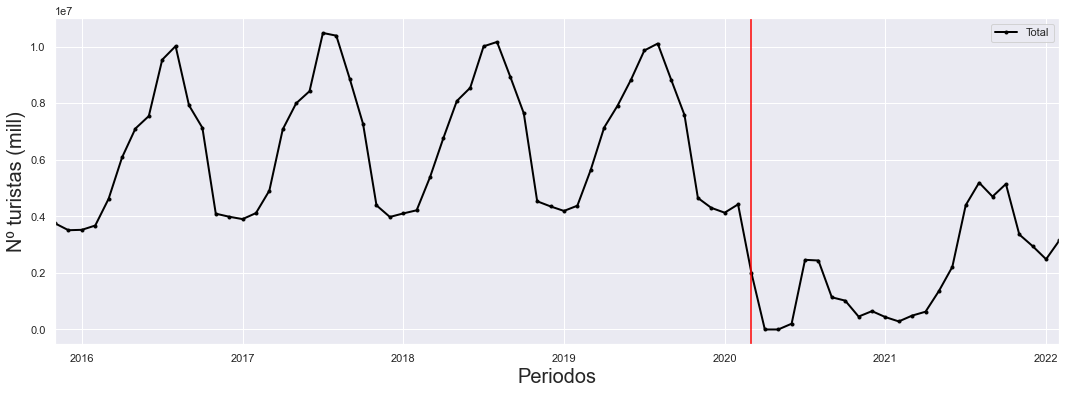

In [21]:
sns.set(rc={'figure.figsize':(18, 6)})
fig = df_turismo.plot(marker='.', color = 'black', linewidth= 2) 
fig.set_ylabel('Nº turistas (mill)', fontsize =20)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Periodos', fontsize = 20);

Como era de esperar, el turismo tiene una estacionalidad bastante clara habiendo máximos en los meses de verano y mínimos en la època de Navidad. Cuando llega la época del COVID, el turismo se desploma y ahora va recuperándose poco a poco con la ayuda de las estacionalidad, donde ya se ven pequeños máximos en el verano del 2021.


A continuación, analizaremos la estacionalidad mediante:
- Cálculo de la media y de la varianza
- Gráficas de comportamiento mensual
- Desglose de la tendencia, de la estacionalidad y residuos

In [37]:
def split_and_summarize(dataframe, column, size, fn):
    ranges = []
    values = []
    for i in range(0, len(dataframe), size):
        ranges.append(dataframe[i:i + size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

In [38]:
media = split_and_summarize(df_turismo, 'Total', 4, np.mean)

varianza = split_and_summarize(df_turismo, 'Total', 4, np.var)

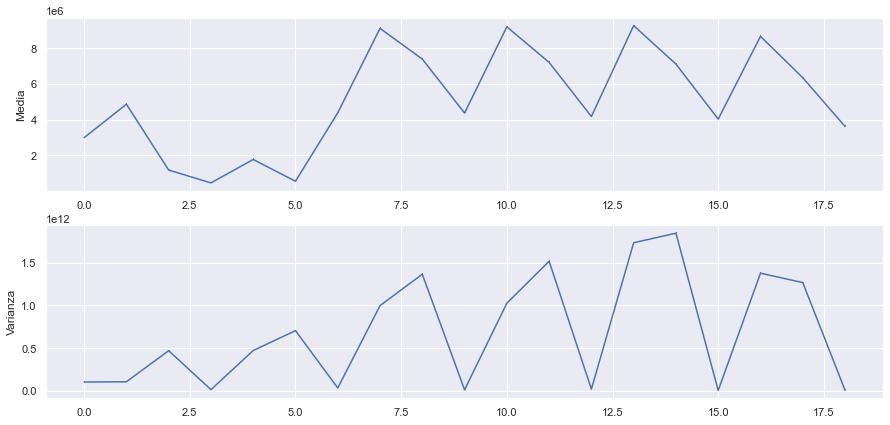

In [39]:
cols = ['media', 'varianza']
df = pd.DataFrame([media, varianza], index=cols)

sns.set(rc={'figure.figsize':(15, 7)})
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(media, ',-')
ax1.set_ylabel('Media')

ax2.plot(varianza, ',-')
ax2.set_ylabel('Varianza')

plt.show()

A continuación vamos a analizar con más detalle la estacionalidad y su tendencia:

<font color='red'> CORREGIR ESTO
   
</font>

ValueError: Expected frequency -1MS. Got M

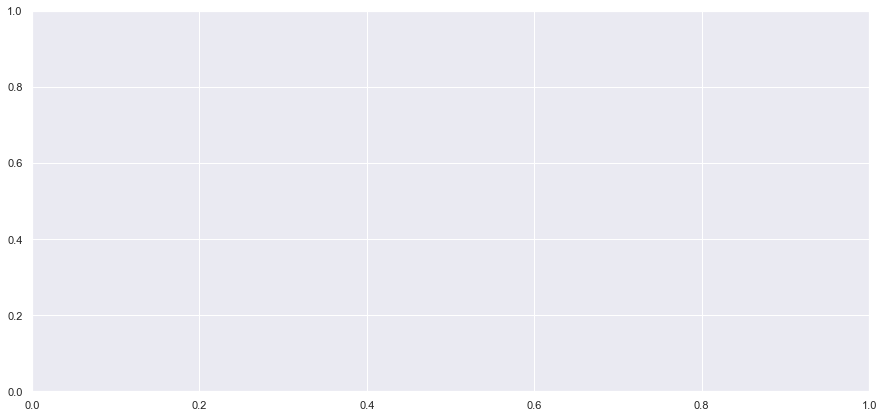

In [40]:
# Componente estacional mensual:
ax = plt.gca() 
sm.graphics.tsa.month_plot(df_turismo['Total'], ax = ax)
ax.set_title('Comportamiento mensual', fontsize = 30);

Pasamos a realizar un boxplot mensual para estudiar las distribuciones:

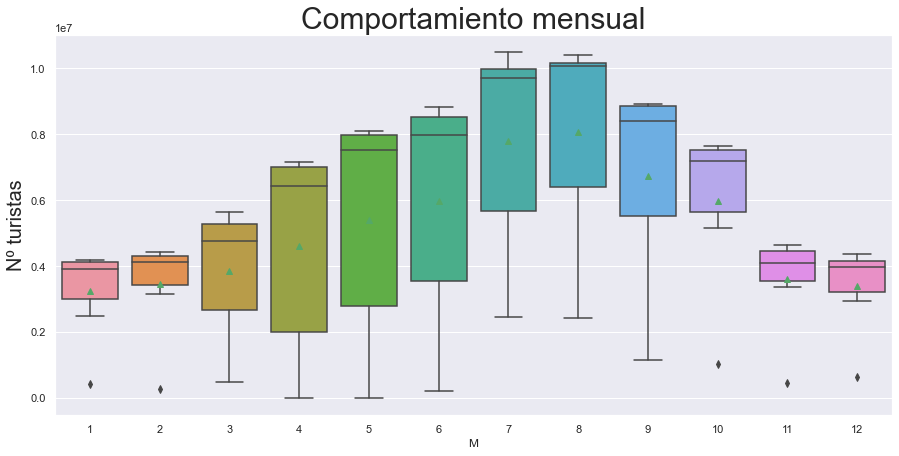

In [41]:
df_turismo['M'] = df_turismo.index.month
sns.boxplot(data = df_turismo, x = 'M', y='Total', showmeans=True)
ax = plt.gca()
ax.set_ylabel('Nº turistas', fontsize = 20)
ax.set_title('Comportamiento mensual', fontsize = 30);

Y, por último, el desglose de la estacionalidad, tendencia y residuos:

<font color='red'>REORDENAR LOS AÑOS, ESTÁN DEL REVÉS</font>

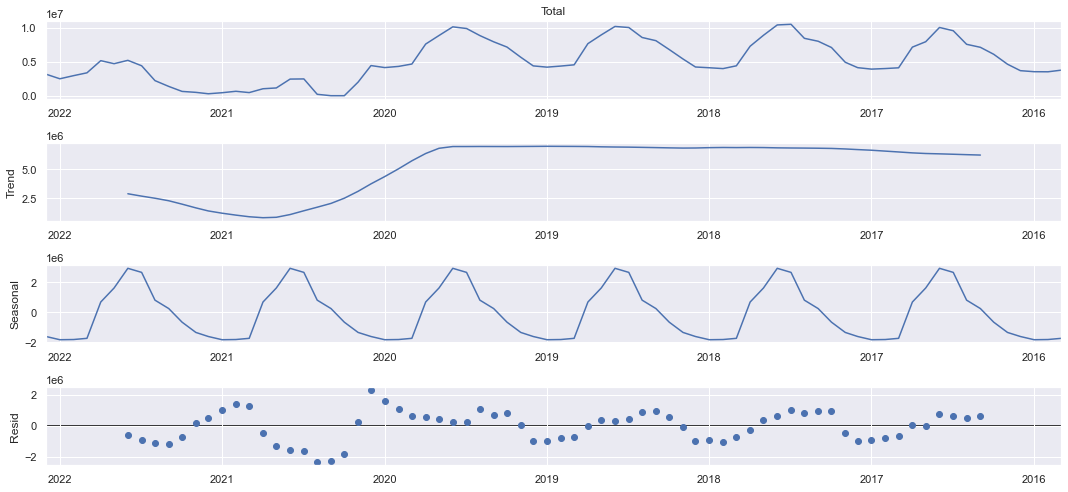

In [43]:
desglose = seasonal_decompose(df_turismo['Total'], 
                                   model='additive', 
                                   period=12);
desglose.plot();

Analizando las gráficas, observamos:

- Que no existe una tendencia hasta el momento COVID, en el que realiza un descenso del turismo. Ahora mismo está en proceso de recuperación y en tendencia creciente.
- Que sí es una serie estacionaria, ya que su media y su varianza son, por lo general, constantes a lo largo del periodo. 
- Que existen unas claras oscilaciones fijas dentro del año y que ya lo hemos mencionado anteriormente: existe una clara estacionalidad donde hay más turismo en los meses de verano y donde hay mínimos en la època de Navidad. 